In [1]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import cai
import cai.util
import cai.inception_v3
import cai.layers
from cai.layers import conv2d_bn

In [2]:
def two_path5_inception_v3(
                include_top=True,
                weights=None, #'two_paths_plant_leafs'
                input_shape=(224,224,3),
                pooling=None,
                classes=1000,
                two_paths=False,
                deep_two_paths=False,
                deep_two_paths_compression=0.655,
                deep_two_paths_bottleneck_compression=0.5,
                l_ratio=0.5,
                ab_ratio=0.5,
                max_mix_idx=10,
                max_mix_deep_two_paths_idx=-1,
                model_name='two_path_inception_v3',
                kType=0,
                **kwargs
):
    """
    Instantiates the Inception v3 architecture with 2 paths options.
    """
    img_input = keras.layers.Input(shape=input_shape)
    if (deep_two_paths):  max_mix_deep_two_paths_idx = max_mix_idx

    if keras.backend.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    

    if two_paths:
        if (l_ratio>0):
            l_branch = cai.layers.CopyChannels(0,1)(img_input)
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, strides=(2, 2), padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(64*l_ratio)), 3, 3)
            l_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(l_branch)

            #l_branch    = conv2d_bn(x, int(round(80*deep_two_paths_bottleneck_compression)), 1, 1, padding='valid', name='second_block_ta', activation=None, has_batch_norm=True)
            l_branch    = cai.inception_v3.create_inception_path(last_tensor=l_branch, compression=deep_two_paths_bottleneck_compression, channel_axis=channel_axis, name='second_block_ta', activation=None, has_batch_norm=True, kType=kType)
            # l_branch    = conv2d_bn(l_branch,    int(round(80 *deep_two_paths_compression)), 1, 1, padding='valid')
            l_branch = cai.inception_v3.kInceptionPointwise(l_branch, filters=int(round(80 *l_ratio)), name='l_branch_path', kType=kType)
            l_branch    = conv2d_bn(l_branch,    int(round(192*l_ratio)), 3, 3, padding='valid')

        if (ab_ratio>0):
            ab_branch = cai.layers.CopyChannels(1,2)(img_input)
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, strides=(2, 2), padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(64*ab_ratio)), 3, 3)
            ab_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(ab_branch)

            #ab_branch = conv2d_bn(x, int(round(80*deep_two_paths_bottleneck_compression)), 1, 1, padding='valid', name='second_block_tb', activation=None, has_batch_norm=True)
            ab_branch = cai.inception_v3.create_inception_path(last_tensor=ab_branch, compression=deep_two_paths_bottleneck_compression, channel_axis=channel_axis, name='second_block_tb', activation=None, has_batch_norm=True, kType=kType)
            # ab_branch = conv2d_bn(ab_branch, int(round(80 *deep_two_paths_compression)), 1, 1, padding='valid')
            ab_branch = cai.inception_v3.kInceptionPointwise(ab_branch, filters=int(round(80 *ab_ratio)), name='ab_branch_path', kType=kType)
            ab_branch = conv2d_bn(ab_branch, int(round(192*ab_ratio)), 3, 3, padding='valid')
        
        if (l_ratio>0):
            if (ab_ratio>0):
                x = keras.layers.Concatenate(axis=channel_axis, name='concat_first_block')([l_branch, ab_branch])
            else:
                x = l_branch
        else:
            x = ab_branch
    else:
        single_branch = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
        single_branch = conv2d_bn(single_branch, 32, 3, 3, padding='valid')
        single_branch = conv2d_bn(single_branch, 64, 3, 3)
        single_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(single_branch)

        # x = conv2d_bn(x, 80, 1, 1, padding='valid')
        x = cai.inception_v3.kInceptionPointwise(single_branch, filters=80, name='single_path', kType=kType)
        x = conv2d_bn(single_branch, 192, 3, 3, padding='valid')

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)    

    if max_mix_idx >= 0:
        for id_layer in range(max_mix_idx+1):
            if (max_mix_deep_two_paths_idx >= id_layer):
                x = cai.inception_v3.create_inception_v3_two_path_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer),
                    channel_axis=channel_axis, bottleneck_compression=deep_two_paths_bottleneck_compression, 
                    compression=deep_two_paths_compression, has_batch_norm=True, kType=kType)
            else:
                x = cai.inception_v3.create_inception_v3_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer), channel_axis=channel_axis, kType=kType)
    
    if include_top:
        # Classification block
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = keras.layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = keras.models.Model(inputs, x, name=model_name)
    return model

In [11]:
def two_path5_inception_v5(
                include_top=True,
                weights=None, #'two_paths_plant_leafs'
                input_shape=(224,224,3),
                pooling=None,
                classes=1000,
                two_paths=False,
                deep_two_paths=False,
                deep_two_paths_compression=0.655,
                deep_two_paths_bottleneck_compression=0.5,
                l_ratio=0.5,
                ab_ratio=0.5,
                max_mix_idx=10,
                max_mix_deep_two_paths_idx=-1,
                model_name='two_path_inception_v3',
                kType=0,
                **kwargs):
    """
    Instantiates the Inception v3 architecture with 2 paths options.
    """
    img_input = keras.layers.Input(shape=input_shape)
    if (deep_two_paths):  max_mix_deep_two_paths_idx = max_mix_idx

    if keras.backend.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    

    if two_paths:
        if (l_ratio>0):
            l_branch = cai.layers.CopyChannels(0,1)(img_input)
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, strides=(2, 2), padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), 3, 3, padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(64*l_ratio)), 3, 3)
            l_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(l_branch)

            l_branch = conv2d_bn(l_branch, int(round(80*l_ratio)), 1, 1, padding='valid')
            l_branch = conv2d_bn(l_branch, int(round(192*l_ratio)), 3, 3, padding='valid') 

        if (ab_ratio>0):
            ab_branch = cai.layers.CopyChannels(1,2)(img_input)
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, strides=(2, 2), padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), 3, 3, padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(64*ab_ratio)), 3, 3)
            ab_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(ab_branch)

            ab_branch = conv2d_bn(ab_branch, int(round(80*ab_ratio)), 1, 1, padding='valid')
            ab_branch = conv2d_bn(ab_branch, int(round(192*ab_ratio)), 3, 3, padding='valid')            
        
        if (l_ratio>0):
            if (ab_ratio>0):
                x = keras.layers.Concatenate(axis=channel_axis, name='concat_first_block')([l_branch, ab_branch])
            else:
                x = l_branch
        else:
            x = ab_branch
    else:
        single_branch = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
        single_branch = conv2d_bn(single_branch, 32, 3, 3, padding='valid')
        single_branch = conv2d_bn(single_branch, 64, 3, 3)
        single_branch = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(single_branch)

        # x = conv2d_bn(x, 80, 1, 1, padding='valid')
        x = cai.inception_v3.kInceptionPointwise(single_branch, filters=80, name='single_path', kType=kType)
        x = conv2d_bn(single_branch, 192, 3, 3, padding='valid')

    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)    

    if max_mix_idx >= 0:
        for id_layer in range(max_mix_idx+1):
            if (max_mix_deep_two_paths_idx >= id_layer):
                x = cai.inception_v3.create_inception_v3_two_path_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer),
                    channel_axis=channel_axis, bottleneck_compression=deep_two_paths_bottleneck_compression, 
                    compression=deep_two_paths_compression, has_batch_norm=True, kType=kType)
            else:
                x = cai.inception_v3.create_inception_v3_mixed_layer(x,  id=id_layer,  name='mixed'+str(id_layer), channel_axis=channel_axis, kType=kType)
    
    if include_top:
        # Classification block
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = keras.layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = keras.models.Model(inputs, x, name=model_name)
    return model

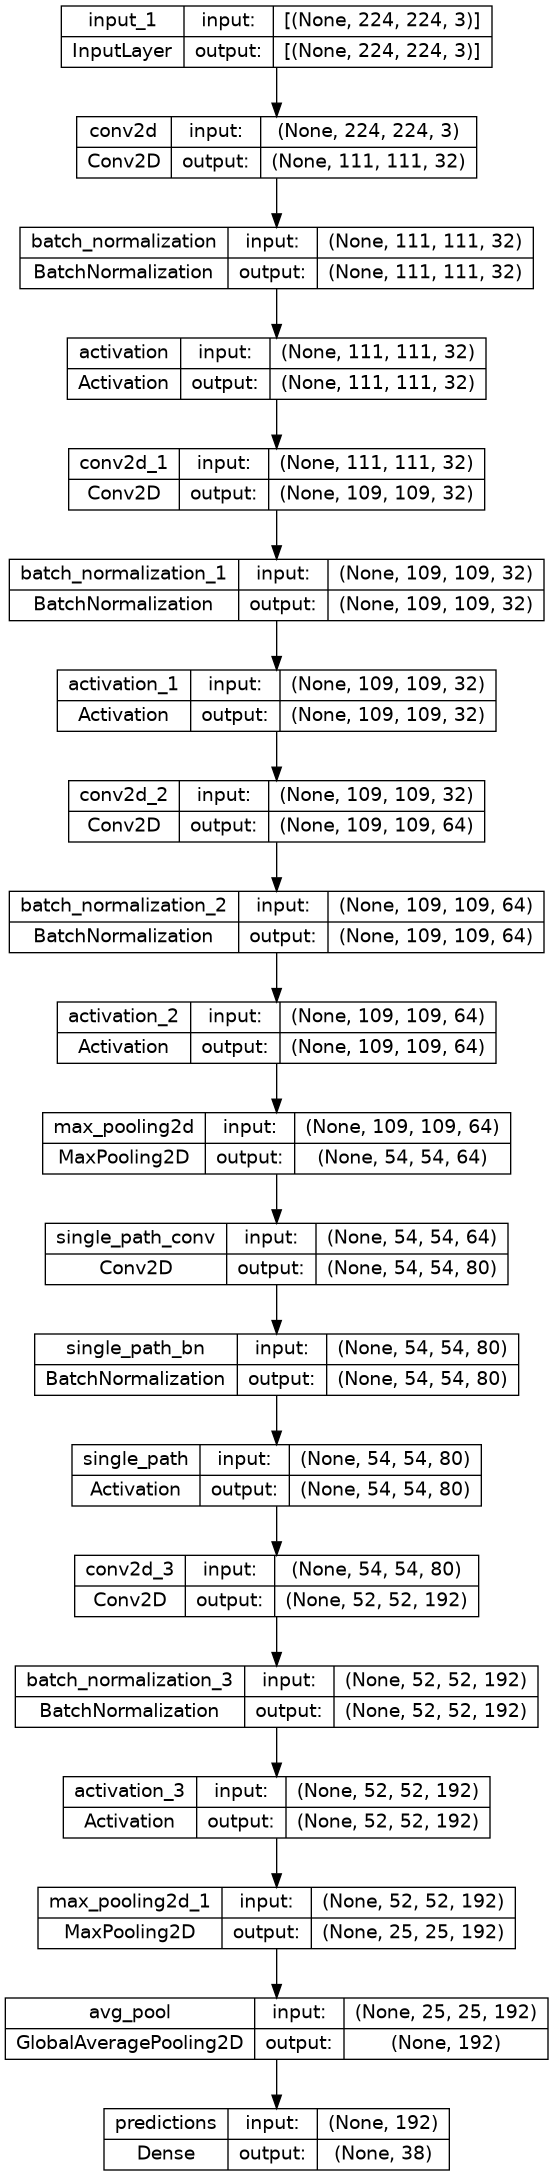

In [3]:
inception_model = cai.inception_v3.two_path_inception_v3(
        input_shape=(224,224,3),
        classes=38, 
        two_paths_first_block=False,
        two_paths_second_block=False,        
        l_ratio=0.25,
        ab_ratio=(1.0-0.25),
        max_mix_idx=-1, 
        model_name='inception_v3_mixed5'
)

plot_model(inception_model, to_file='inception_model.png', show_shapes=True, show_layer_names=True)

Model: "two_path_inception_v3_mixed0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 copy_channels_19 (CopyChan  (None, 224, 224, 1)          0         ['input_13[0][0]']            
 nels)                                                                                            
                                                                                                  
 copy_channels_20 (CopyChan  (None, 224, 224, 2)          0         ['input_13[0][0]']            
 nels)                                                                                            
                                                                       

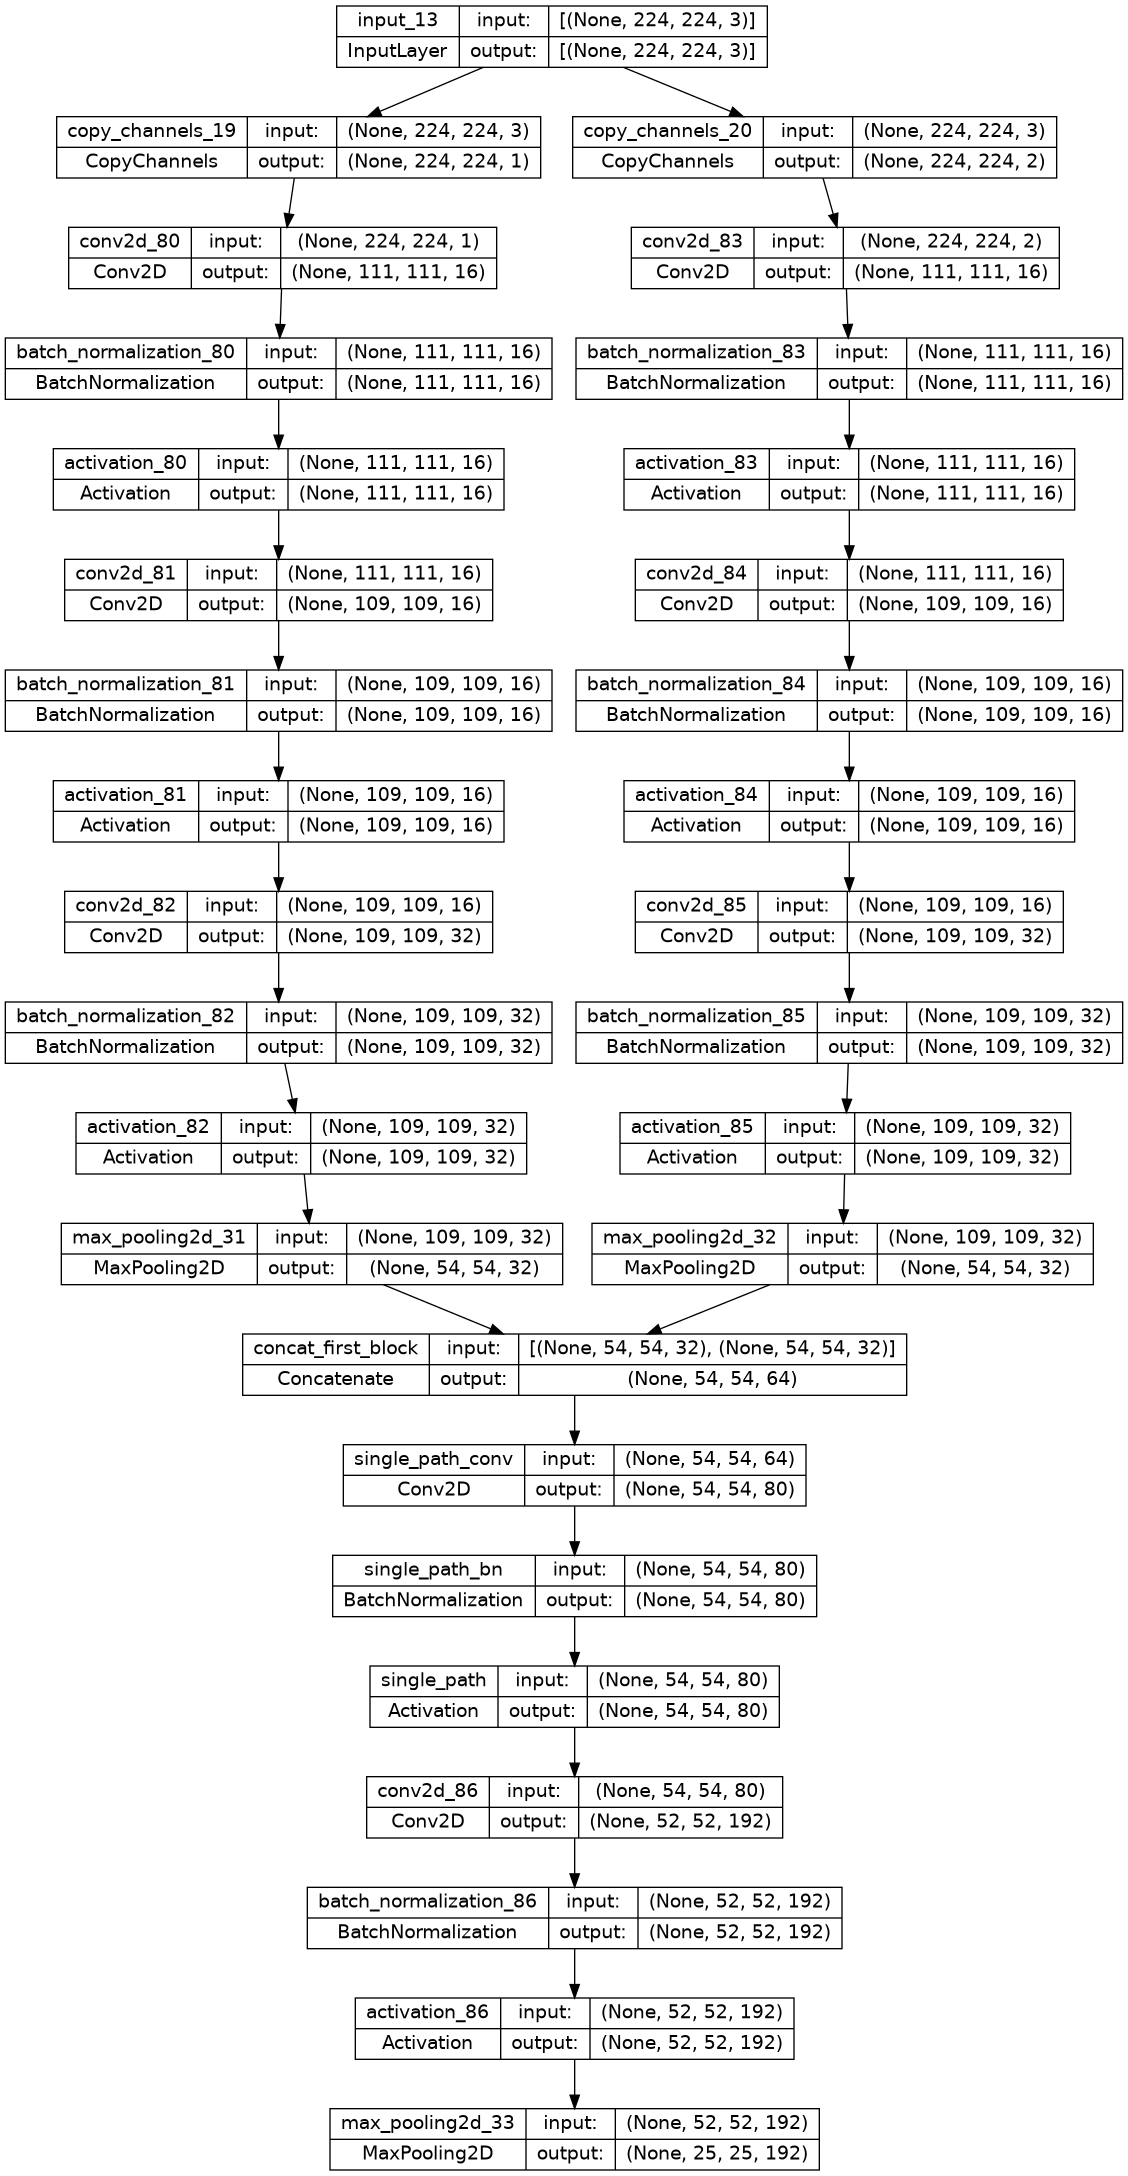

In [18]:
twopath_model = cai.inception_v3.two_path_inception_v3(
        include_top=False,
        input_shape=(224,224,3),
        classes=38, 
        two_paths_first_block=True,
        two_paths_second_block=False,        
        l_ratio=0.5,
        ab_ratio=0.5,
        max_mix_idx=-1, 
        model_name='two_path_inception_v3_mixed0'
)

twopath_model.summary()
plot_model(twopath_model, to_file='twopath_model.png', show_shapes=True, show_layer_names=True)

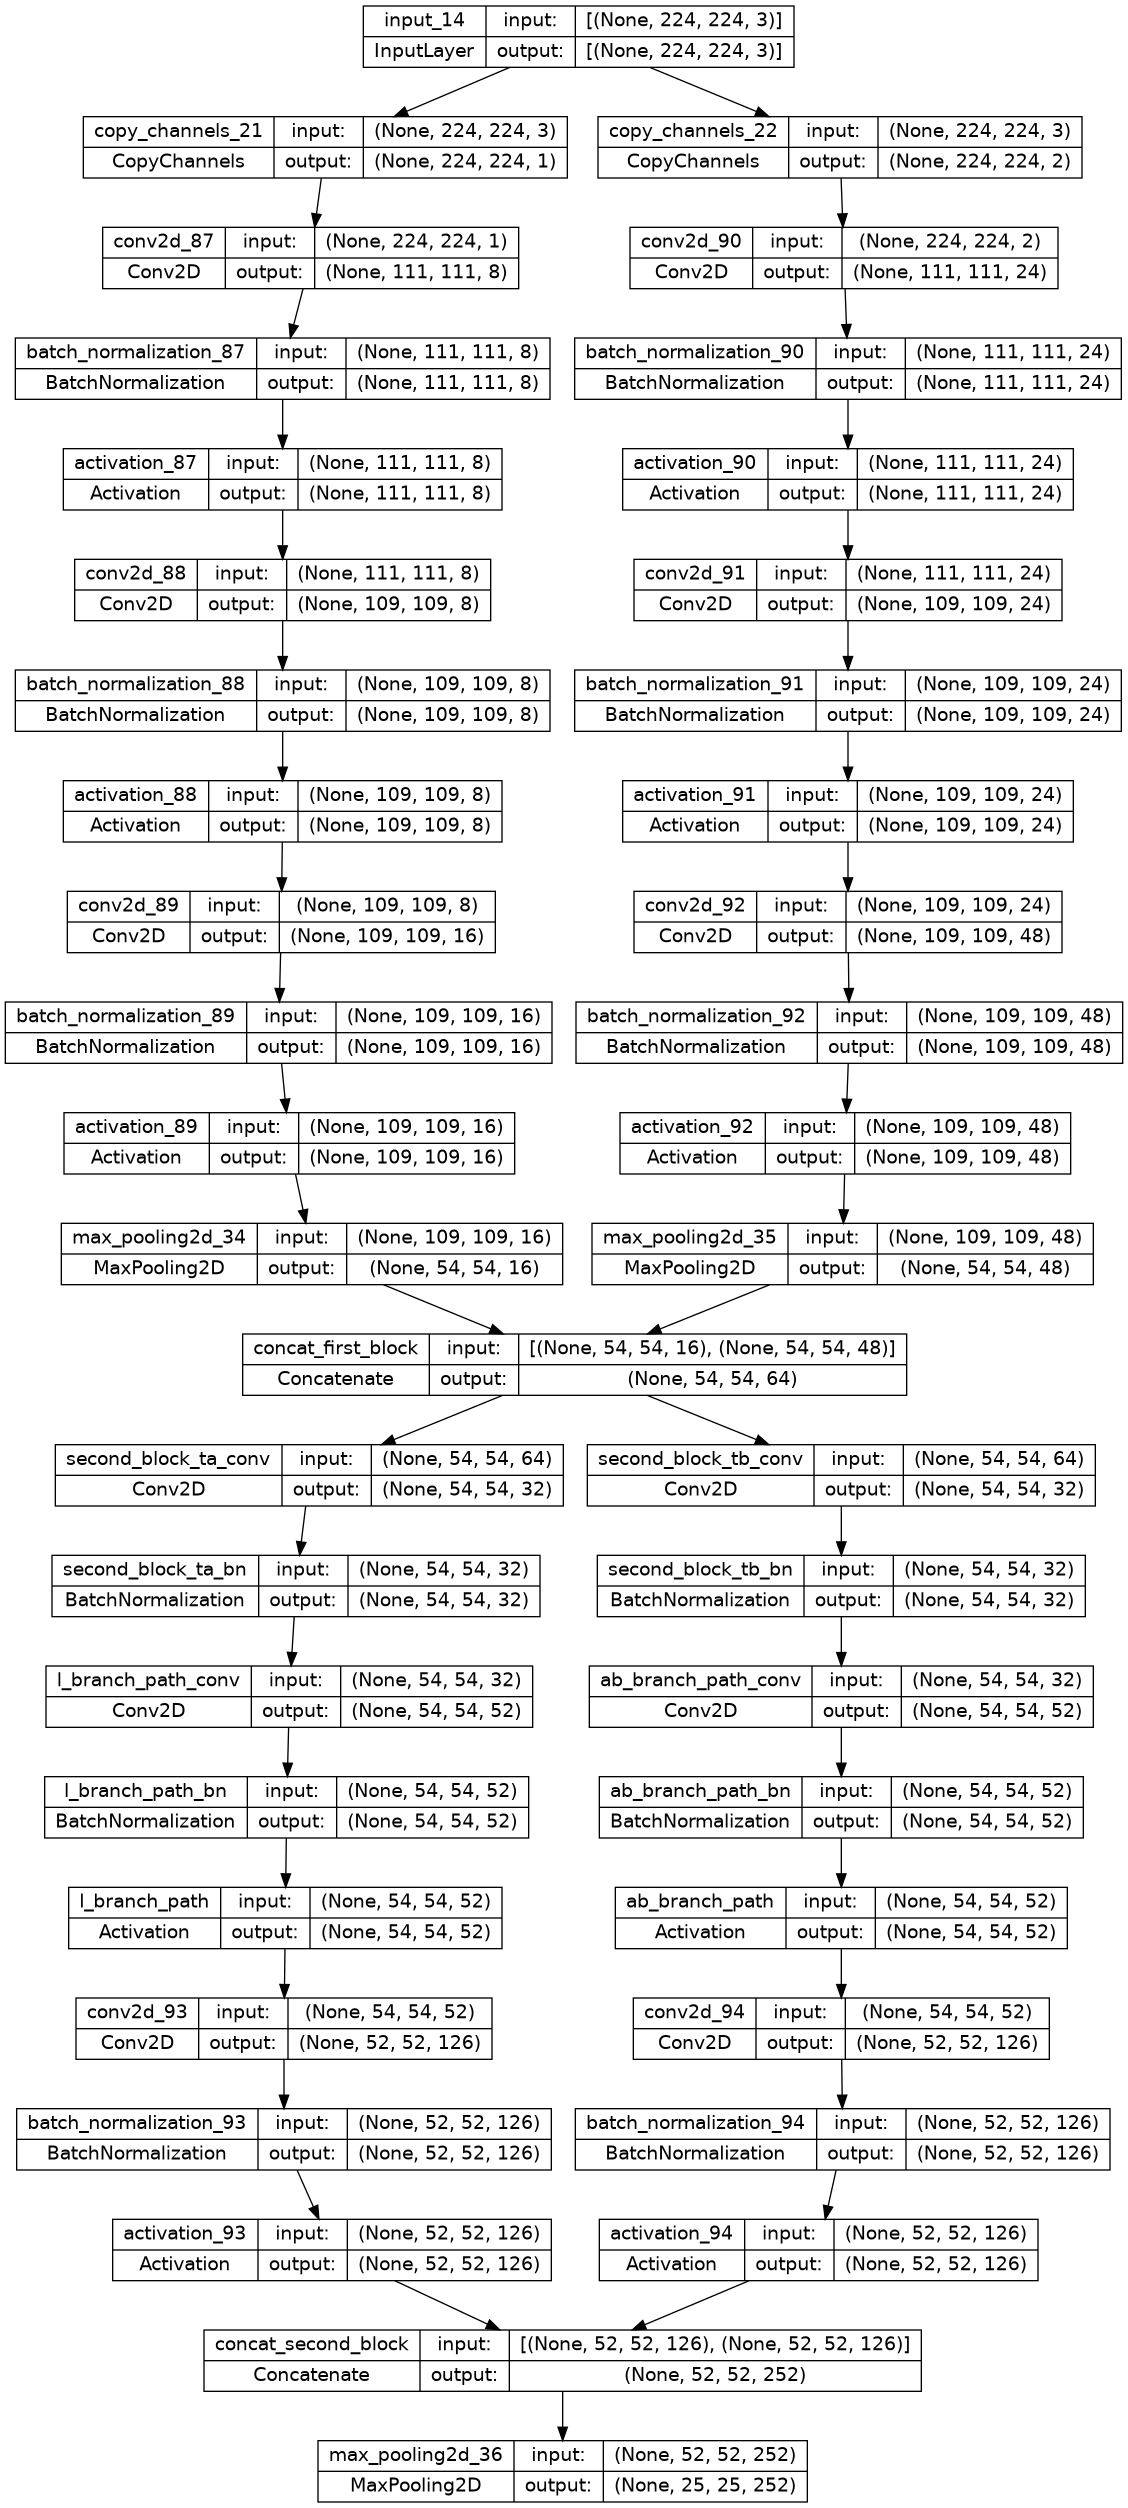

In [19]:
twopathx2_model = cai.inception_v3.two_path_inception_v3(
        include_top=False,
        input_shape=(224,224,3),
        classes=38, 
        two_paths_first_block=True,
        two_paths_second_block=True,        
        l_ratio=0.25,
        ab_ratio=(1.0-0.25),
        max_mix_idx=-1, 
        model_name='two_path_inception_v3_mixed5'
)

plot_model(twopathx2_model, to_file='twopathx2_model.png', show_shapes=True, show_layer_names=True)

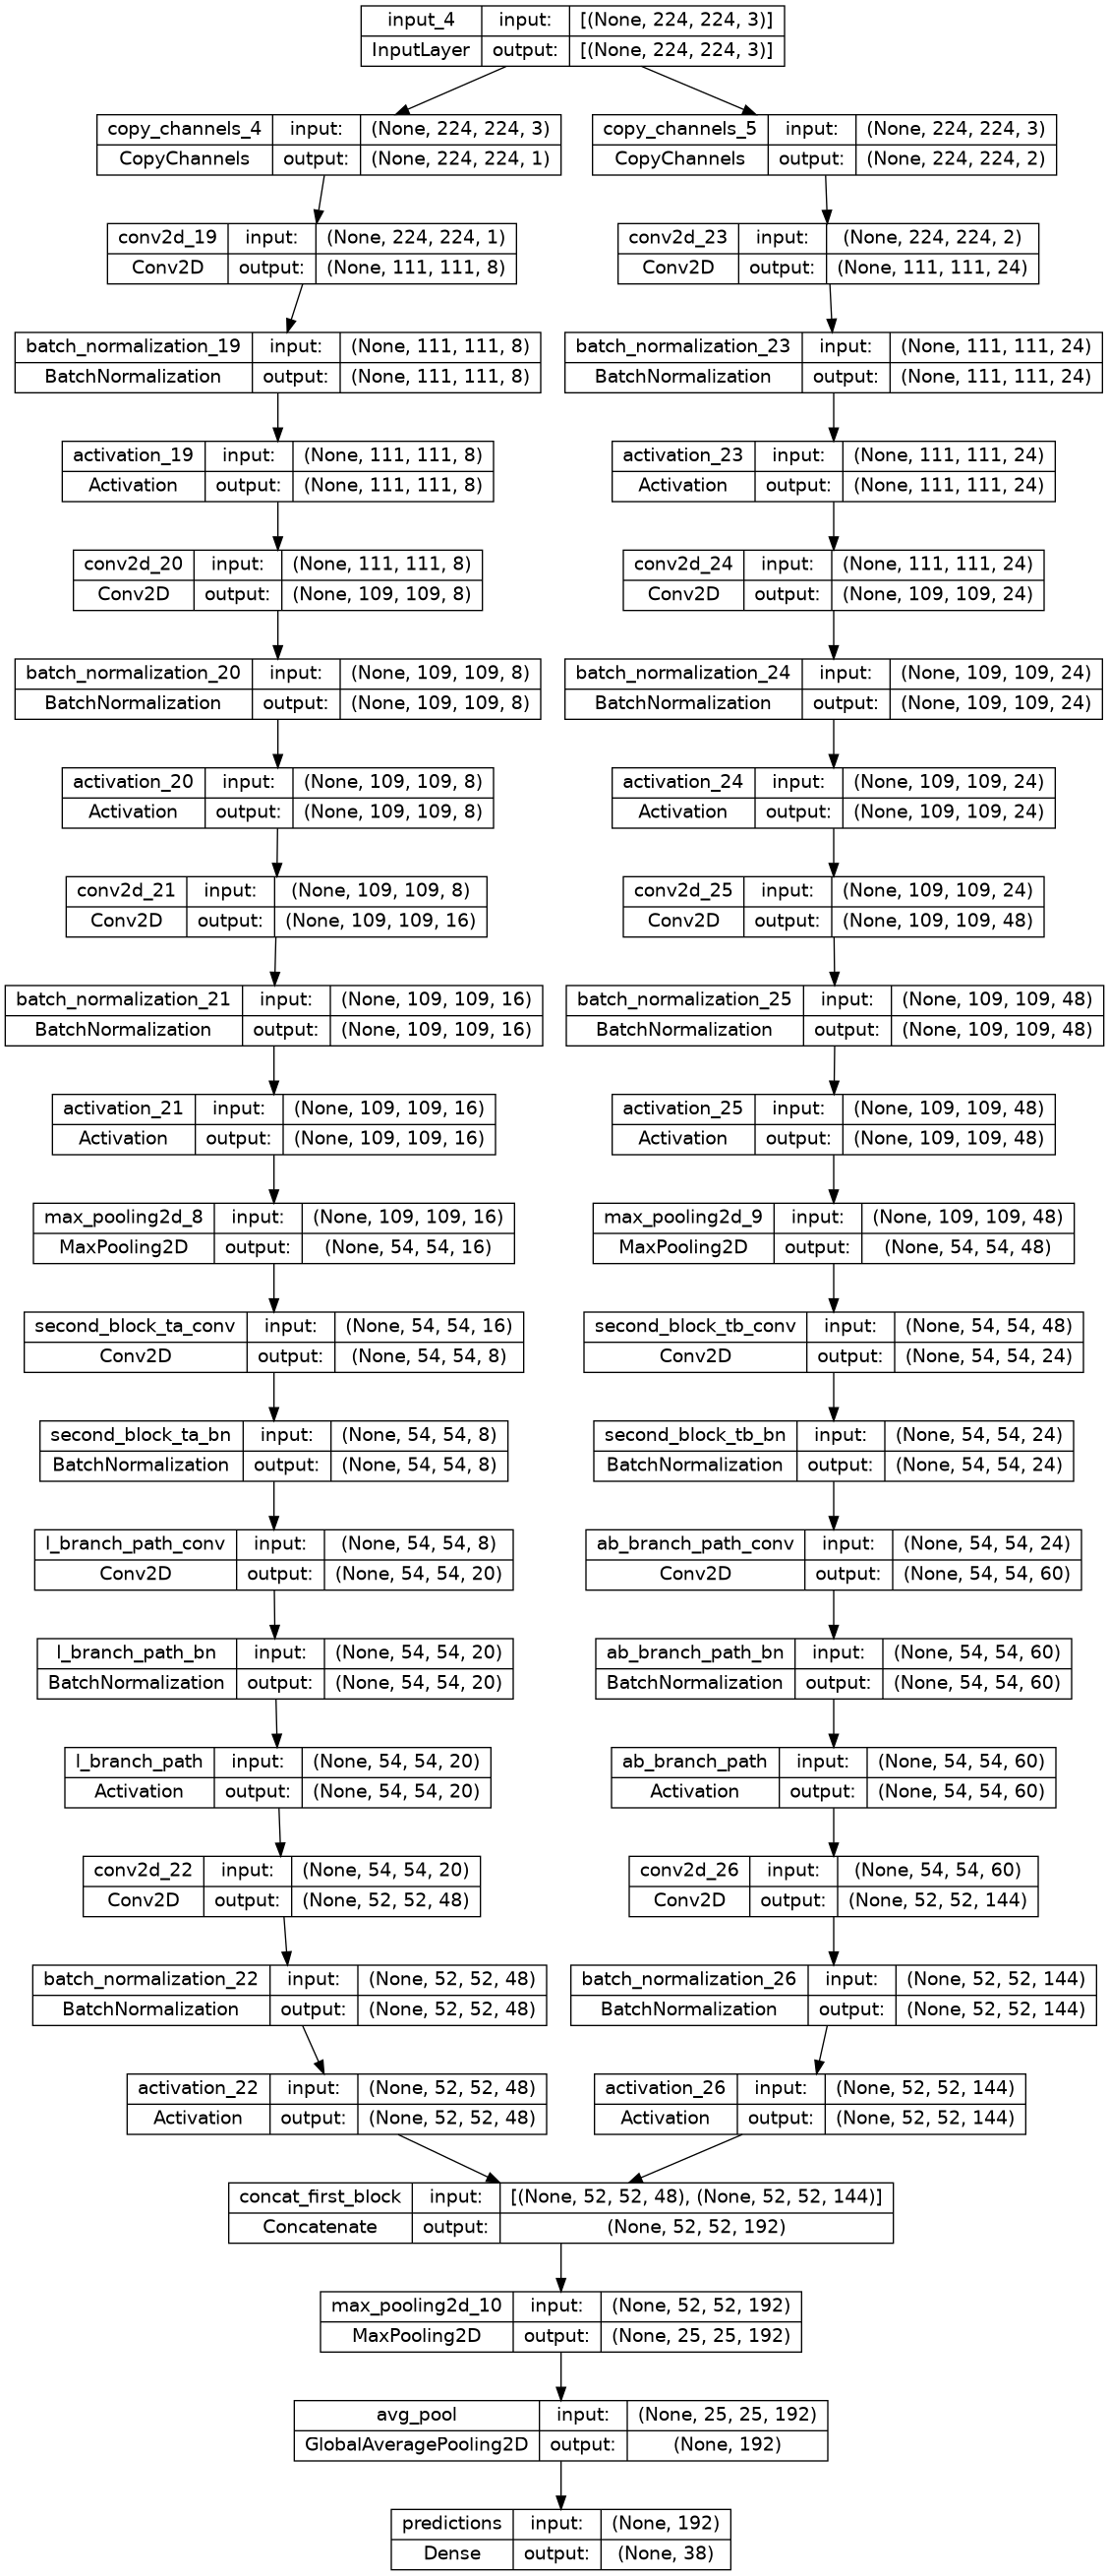

In [6]:
twopath5_model=two_path5_inception_v3(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,3),
    two_paths=True,    
    pooling='max',
    classes=38,
    l_ratio=0.25,
    ab_ratio=0.75,
    max_mix_idx=-1
)
plot_model(twopath5_model, to_file='twopath5_model.png', show_shapes=True, show_layer_names=True)

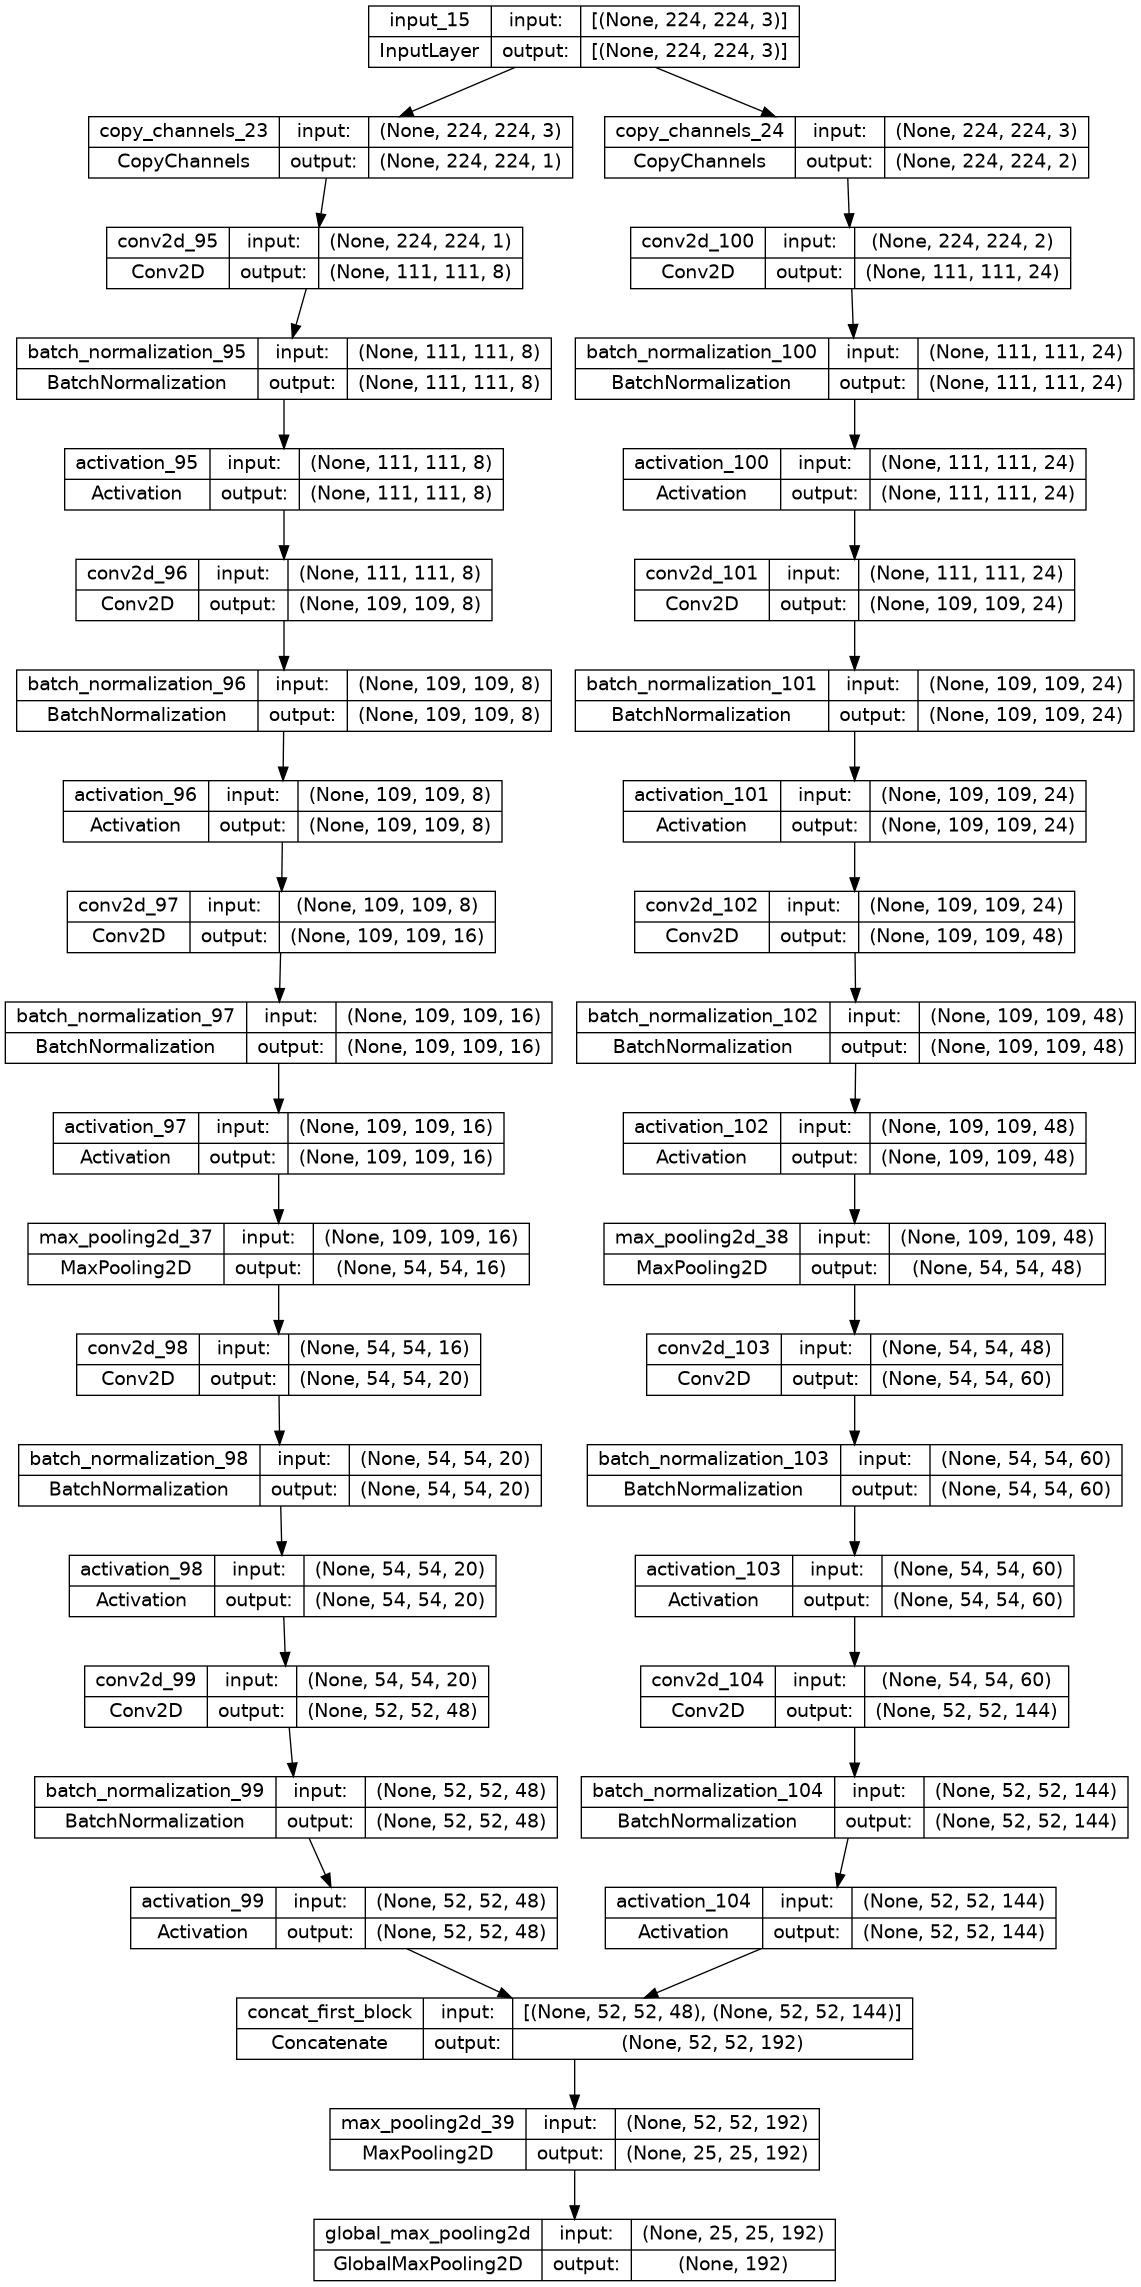

In [20]:
twopath5_new_model=two_path5_inception_v5(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,3),
    two_paths=True,    
    pooling='max',
    classes=38,
    l_ratio=0.25,
    ab_ratio=0.75,
    max_mix_idx=-1
)
plot_model(twopath5_new_model, to_file='twopath5_new_model.png', show_shapes=True, show_layer_names=True)